In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations

import jax.numpy as jnp
import jax
from pathlib import Path
from diffwake.diffwake_jax.model import load_input, create_state, turbine_powers, alter_yaw_angles
from diffwake.diffwake_jax.simulator import simulate, simulate_simp
from diffwake.diffwake_jax.turbine.operation_models import power as power_fn
from diffwake.diffwake_jax.util import set_precision
from floris import FlorisModel, TimeSeries
import numpy as np
from diffwake.diffwake_jax.model import load_input, create_state
from diffwake.diffwake_jax.yaw_runner import make_yaw_runner
from diffwake.diffwake_jax.util import average_velocity_jax
from diffwake.diffwake_jax.turbine.operation_models import power
import time


# helper functions
def absolute_percentage_difference(a, b):
    return jnp.abs((a - b) / b) * 100

def average_velocity_jax(v, method="cubic-mean"):
    if method == "simple-mean":
        return jnp.mean(v, axis=(-2, -1), keepdims=True)
    if method == "cubic-mean":
        m3 = jnp.mean(v**3, axis=(-2, -1), keepdims=True)
        return jnp.cbrt(m3)                 # exact libm cbrt, matches Torch
    raise ValueError

DTYPE = set_precision("float64")
print(f"Current floating point precision: {DTYPE}")

Current floating point precision: <class 'jax.numpy.float64'>


## DiffWake yawed vs unyawed comparisons

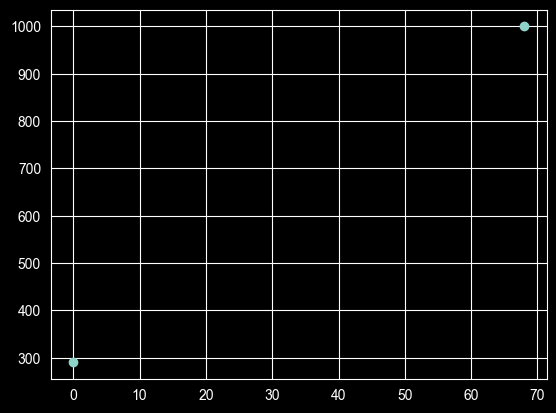

In [12]:
import matplotlib.pyplot as plt

debug_dir = Path("data/debug")
farm_cfg_path = debug_dir / "gch.yaml"
turbine_path = debug_dir / "vestas_v802MW.yaml"

debug_cfg = load_input(farm_cfg_path, turbine_path)
lx = debug_cfg.layout['layout_x']
ly = debug_cfg.layout['layout_y']
plt.scatter(lx, ly)

In [5]:
# 1. Define paths to configuration files
# wake_model = "gauss"
# data_dir = Path("data/horn")
# farm_cfg_path = data_dir / f"{wake_model}_hornsRev.yaml"
# turbine_cfg_path = data_dir / "vestas_v802MW.yaml"

wake_model = "gauss"
data_dir = Path("data/three_square")
farm_cfg_path = data_dir / f"gch.yaml"
turbine_cfg_path = data_dir / "vestas_v802MW.yaml"


# 2. Load the base configuration
base_cfg = load_input(farm_cfg_path, turbine_cfg_path)

# 3. Define a simple 3-turbine layout (aligned along the X-axis)
ws = 13.5
wd = 270.0
ti_val = 0.06
# layout_x = jnp.array([0.0, 400.0, 800.0], dtype=DTYPE)
# layout_y = jnp.array([0.0, 0.0, 0.0], dtype=DTYPE)

# 4. Define flow conditions
wind_speed = jnp.array([ws], dtype=DTYPE)
wind_dir = jnp.array([jnp.deg2rad(wd)], dtype=DTYPE) # Wind from West
ti = jnp.array([ti_val], dtype=DTYPE)

# 5. Update the configuration
cfg = base_cfg.set(
    # layout_x=layout_x,
    # layout_y=layout_y,
    wind_speeds=wind_speed,
    wind_directions=wind_dir,
    turbulence_intensities=ti
)

# hr1_cfg = base_cfg.set(
#     wind_speeds=wind_speed,
#     wind_directions=wind_dir,
#     turbulence_intensities=ti
# )

# 6. Create the simulation state
state = create_state(cfg)
# hr1_state = create_state(hr1_cfg)

# --- Baseline: Unyawed Farm ---
yaw_angles_unyawed = jnp.zeros((1, 9), dtype=DTYPE) # (n_findex, n_turbines)
# hr1_yaw_angles_unyawed = jnp.zeros((1, 80), dtype=DTYPE)

state_unyawed = alter_yaw_angles(yaw_angles_unyawed, state)
# hr1_state_unyawed = alter_yaw_angles(hr1_yaw_angles_unyawed, hr1_state)

result_unyawed = simulate(state_unyawed)
# hr1_result_unyawed = simulate(hr1_state)
unyawed_vel = average_velocity_jax(result_unyawed.u_sorted)

unyawed_turbine_powers = power_fn(power_thrust_table=state_unyawed.farm.power_thrust_table,
                                  velocities=result_unyawed.u_sorted,
                                  air_density=state_unyawed.flow.air_density,
                                  yaw_angles=state_unyawed.farm.yaw_angles,)
# unyawed_hr1_turbine_powers = power_fn(power_thrust_table=hr1_state_unyawed.farm.power_thrust_table,
#                                       velocities=hr1_result_unyawed.u_sorted,
#                                       air_density=hr1_state_unyawed.flow.air_density,
#                                       yaw_angles=hr1_state_unyawed.farm.yaw_angles)

unyawed_farm_power = jnp.sum(unyawed_turbine_powers)/1e6 # convert to megawatts
# unyawed_hr1_farm_power = jnp.sum(unyawed_hr1_turbine_powers)/1e6

# # --- Case: Yawed Farm ---
# y1, y2, y3 = 12.12434997, 20.76370488, 16.03151927
y1, y2, y3, y4, y5, y6, y7, y8, y9 = 25.0, 25.0, 25.0, 15.52, 15.34, 15.27, 0.0, 0.0, 0.0
yaw_angles_deg = jnp.array([[y1, y2, y3, y4, y5, y6, y7, y8, y9]], dtype=DTYPE) # Try steering wakes away from downstream turbines
yaw_angles_rad = jnp.deg2rad(yaw_angles_deg)

state_yawed = alter_yaw_angles(yaw_angles_rad, state)
result_yawed = simulate(state_yawed)
yawed_vel = average_velocity_jax(result_yawed.u_sorted)
yawed_turbine_powers = power_fn(power_thrust_table=state_yawed.farm.power_thrust_table,
                                  velocities=result_yawed.u_sorted,
                                  air_density=state_yawed.flow.air_density,
                                  yaw_angles=state_yawed.farm.yaw_angles,)
yawed_farm_power = jnp.sum(yawed_turbine_powers)/1e6

# Yawing HR1
# hr1_yaw_angles_deg = jnp.concat([jnp.full((1, 70), 10, dtype=DTYPE), jnp.zeros((1, 10), dtype=DTYPE)], axis=1)
# hr1_yaw_angles_rad = jnp.deg2rad(hr1_yaw_angles_deg)
#
# hr1_state_yawed = alter_yaw_angles(hr1_yaw_angles_rad, hr1_state)
# hr1_result_yawed = simulate(hr1_state_yawed)
# hr1_yawed_turbine_powers = power_fn(power_thrust_table=hr1_state_yawed.farm.power_thrust_table,
#                                     velocities=hr1_result_yawed.u_sorted,
#                                     air_density=hr1_state_yawed.flow.air_density,
#                                     yaw_angles=hr1_state_yawed.farm.yaw_angles)
# yawed_hr1_farm_power = jnp.sum(hr1_yawed_turbine_powers)/1e6

# # FLORIS YAW
fmodel = FlorisModel(rf"../floris/examples/inputs/{wake_model}_vesta.yaml")
# hr1_fmodel = FlorisModel(rf"../floris/examples/inputs/{wake_model}_vesta.yaml")

floris_yaw_angles = np.array([y1, y2, y3, y4, y5, y6, y7, y8, y9]).reshape(1, -1)
# # hr1_floris_yaw_angles = np.concat([np.full((1, 70), 10), np.zeros((1, 10))], axis=1)
#
time_series = TimeSeries(
    wind_directions=np.array([wd]),
    wind_speeds=np.array([ws]),
    turbulence_intensities=ti_val,
)
# # hr1_fmodel.set(wind_data=time_series,
# #                yaw_angles=np.zeros((1, 80)))

# Sort the coordinates
lx = np.array([0.0, 630.0, 1260.0, 0.0, 630.0, 1260.0, 0.0, 630.0, 1260.0])
ly = np.array([0.0, 0.0, 0.0, 630.0, 630.0, 630.0, -630.0, -630.0, -630.0])

sort_indices = np.argsort(lx)
lx_sorted = lx[sort_indices]
ly_sorted = ly[sort_indices]


fmodel.set(wind_data=time_series,
           layout_x=lx_sorted,
           layout_y=ly_sorted,
           yaw_angles=np.zeros_like(floris_yaw_angles))
fmodel.run()
# hr1_fmodel.run()
#
# # baseline case
floris_baseline_power = fmodel.get_farm_power() / 1e6
# # hr1_floris_baseline_power = hr1_fmodel.get_farm_power() / 1e6
turbine_powers_floris = fmodel.get_turbine_powers()
# # hr1_turbine_powers_floris = hr1_fmodel.get_turbine_powers()
#
#
# # yawed case
# # hr1_fmodel.set(yaw_angles=hr1_floris_yaw_angles)
fmodel.set(yaw_angles=floris_yaw_angles)
# # hr1_fmodel.run()
fmodel.run()
floris_yawed_power = fmodel.get_farm_power() / 1e6
turbine_powers_floris_yawed = fmodel.get_turbine_powers()
# # hr1_floris_yawed_power = hr1_fmodel.get_farm_power() / 1e6
# # hr1_turbine_powers_floris_yawed = hr1_fmodel.get_turbine_powers()

TypeError: mul got incompatible shapes for broadcasting: (1, 20), (1, 9).

In [9]:
print(f"----- FLORIS results -----")
print(f"Baseline farm power: {floris_baseline_power[0]:.6f} MW")
# print(f"Turbine powers: {[i.item() for i in turbine_powers_floris[0]]}" )
print(f"Yawed farm power: {floris_yawed_power[0]:.6f} MW")
# print(f"Turbine powers: {[i.item() for i in turbine_powers_floris_yawed[0]]}\n" )


print(f"----- DiffWake results  -----")
print(f"Baseline farm power: {unyawed_farm_power:.6f} MW")
# print(f"Turbine powers: {[i.item() for i in unyawed_turbine_powers[0]]}" )
print(f"Yawed farm power: {yawed_farm_power:.6f} MW")
# print(f"Turbine powers: {[i.item() for i in yawed_turbine_powers[0]]}\n" )

print("---------- Differences ----------")
print(f"Absolute baseline power difference (GCH) = {absolute_percentage_difference(floris_baseline_power, unyawed_farm_power)[0]:.6f}%")
print(f"Absolute yawed power difference (GCH) = {absolute_percentage_difference(floris_yawed_power, yawed_farm_power)[0]:.6f}%")
# print("="*100)
# print(f"----- FLORIS results (Horns Rev 1)-----")
# print(f"Baseline farm power: {hr1_floris_baseline_power[0]:.6f} MW")
# # print(f"Turbine powers: {[i.item() for i in turbine_powers_floris[0]]}" )
# print(f"Yawed farm power: {hr1_floris_yawed_power[0]:.6f} MW\n")
# # print(f"Turbine powers: {[i.item() for i in turbine_powers_floris_yawed[0]]}\n" )
#
# print(f"----- DiffWake results (Horns Rev 1) -----")
# print(f"Baseline farm power: {unyawed_hr1_farm_power:.6f} MW")
# # print(f"Turbine powers: {[i.item() for i in unyawed_turbine_powers[0]]}" )
# print(f"Yawed farm power: {yawed_hr1_farm_power:.6f} MW")
# # print(f"Turbine powers: {[i.item() for i in yawed_turbine_powers[0]]}" )
# print("\n---------- Differences ----------")
# print(f"Absolute baseline power difference ({wake_model}) = {absolute_percentage_difference(hr1_floris_baseline_power, unyawed_hr1_farm_power)[0]:.6f}%")
# print(f"Absolute yawed power difference ({wake_model}) = {absolute_percentage_difference(hr1_floris_yawed_power, yawed_hr1_farm_power)[0]:.6f}%")



----- FLORIS results -----
Baseline farm power: 16.246120 MW
Yawed farm power: 16.756268 MW
----- DiffWake results  -----
Baseline farm power: 15.798074 MW
Yawed farm power: 16.392811 MW
---------- Differences ----------
Absolute baseline power difference (GCH) = 2.836083%
Absolute yawed power difference (GCH) = 2.217173%


In [4]:
wake_model = "gauss"
fmodel = FlorisModel(rf"../floris/examples/inputs/{wake_model}_vesta.yaml")
# hr1_fmodel = FlorisModel(rf"../floris/examples/inputs/{wake_model}_vesta.yaml")

floris_yaw_angles = np.array([y1, y2, y3, y4, y5, y6, y7, y8, y9]).reshape(1, -1)
# # hr1_floris_yaw_angles = np.concat([np.full((1, 70), 10), np.zeros((1, 10))], axis=1)
#
time_series = TimeSeries(
    wind_directions=np.array([wd]),
    wind_speeds=np.array([ws]),
    turbulence_intensities=ti_val,
)

NameError: name 'y1' is not defined

## Use yaw_runner.py

In [5]:
def build_state_runner(
        data_dir: Path,
        farm_yaml: str,
        turbine_yaml: str,
        wind_dir_rad: jax.Array,
        wind_speed: jax.Array,
        turb_intensity: jax.Array,
        dtype,
):
    cfg = load_input(
        str(data_dir / farm_yaml),
        str(data_dir / turbine_yaml),
    ).set(
        wind_directions=wind_dir_rad,
        wind_speeds=wind_speed,
        turbulence_intensities=turb_intensity,
    )
    state = create_state(cfg)
    runner = make_yaw_runner(state)

    x0 = jnp.asarray(cfg.layout["layout_x"], dtype=dtype)
    N = int(x0.shape[0])

    return state, runner, N

In [28]:
DTYPE = jnp.float64
data_dir = Path("data/horn")
farm_cfg = "gauss_hornsRev.yaml"
turbine_cfg = "vestas_v802MW.yaml"
npz_path = "weather_data_2.npz"
wind_dir = jnp.deg2rad(jnp.array([270.0]))
wind_speed = jnp.array([9.5])
turb_int = jnp.array([0.06])

state, runner, N = build_state_runner(
    data_dir, farm_cfg, turbine_cfg, wind_dir, wind_speed, turb_int, DTYPE
)

zero_yaw = jnp.full((1, N), jnp.deg2rad(8.5), dtype=DTYPE)
out = runner(zero_yaw)

In [29]:
farm_mw = jnp.sum(power(state.farm.power_thrust_table,
               out.u_sorted,
               state.flow.air_density,
               state.farm.yaw_angles)) / 1e6
print(f"Farm power: {farm_mw:.6f} MW")


Farm power: 69.545216 MW


In [30]:
out.u_sorted

Array([[[[9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228]],

        [[9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228]],

        [[9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228]],

        [[9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228]],

        [[9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228]],

        [[9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228]],

        [[9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228],
         [9.12406228, 9.5       , 9.79086228]],


In [23]:
state.farm.yaw_angles

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float64)